<a href="https://colab.research.google.com/github/toaomalkster/conscious-calculator-notebooks/blob/feature%2F20201025-load-existing-notebooks/ConscConcluderV2_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conscious Concluder _(Theory V2)_
0.3:
* Running model in a loop with feedback.
* Simple loss function applied to output nodes on last loop iteration only.

**App Boilerplate**

In [ ]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)


2.3.0


# Setup Training Data

In [ ]:
data = np.random.randint(100, size=(1000, 2)).astype('float32')
data[0:10,:]

array([[99.,  7.],
       [98., 19.],
       [70., 81.],
       [72., 89.],
       [55., 55.],
       [79., 25.],
       [87., 17.],
       [51.,  7.],
       [13., 94.],
       [72., 37.]], dtype=float32)

In [ ]:
data_labels = (data[:,0] + data[:,1])[:,np.newaxis]
data_labels[0:10,:]

array([[106.],
       [117.],
       [151.],
       [161.],
       [110.],
       [104.],
       [104.],
       [ 58.],
       [107.],
       [109.]], dtype=float32)

# Setup Model

In [ ]:
feedbackNodes=5
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(2+feedbackNodes,)),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dense(1+feedbackNodes)
])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 1000)              8000      
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 6006      
Total params: 14,006
Trainable params: 14,006
Non-trainable params: 0
_________________________________________________________________


# Setup Training
Running equivalent of:
```
# fitres = model.fit(data, data_labels, validation_split=0.2, shuffle=True, epochs=150)
```

Trained to run with loop length 5, and asked to calculate 78 + 14, gives the following sub-results:
```
tf.Tensor([[ 20.863955  21.24786   21.903522 -26.444736  23.316566  27.105742]], shape=(1, 6), dtype=float32)
tf.Tensor([[ 20.863955  21.24786   21.903522 -26.444736  23.316566  27.105742]], shape=(1, 6), dtype=float32)
tf.Tensor([[ 57.066494  34.524754  38.432507 -41.519127  35.280796  43.55775 ]], shape=(1, 6), dtype=float32)
tf.Tensor([[ 79.05473   43.883694  47.308945 -51.855434  42.59498   54.392387]], shape=(1, 6), dtype=float32)
tf.Tensor([[ 92.63357   49.677063  52.68658  -58.210316  46.8365    61.155533]], shape=(1, 6), dtype=float32)
```
And the following final result:
```
<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[92.63357]], dtype=float32)>
```

In [ ]:
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
loss = tf.keras.losses.MeanSquaredError()

@tf.function
def predict(inputs, max_loop_length, training=False):
  # initialise feedback
  feedback = tf.zeros(shape=(inputs.shape[0], feedbackNodes))

  for i in range(max_loop_length):
    # extend width of inputs with zeroed-out feedback
    inputsWithFeedback = tf.concat([inputs, feedback], axis=1)
  
    # run model with inputs+feedback
    output = model(inputsWithFeedback, training)

    # copy feedback for next loop
    feedback = output[:,-feedbackNodes:]

  # produce result of model loop
  return output[:,:-feedbackNodes]

@tf.function
def train_step(inputs, expected, max_loop_length):
  with tf.GradientTape() as tape:
    output = predict(inputs, max_loop_length, training=True)

    # calculate loss ignoring feedback output
    loop_loss = loss(output, expected)

    # train model
    gradients = tape.gradient(loop_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loop_loss

In [ ]:
def fit(train_data, train_labels, epochs, batch_size, max_loop_length):
  res = {}
  res['loss'] = []

  for epoch in range(epochs):
    print ('Epoch: {}/{}'.format(epoch+1, epochs))
    start = time.time()
    sum_loss = 0

    # Train in batches
    mx = (int(len(train_data)/batch_size))*batch_size
    n  = mx/batch_size
    print ('[', end='')
    for i in range(0, mx, batch_size):
      batch_data   = train_data[i:i+batch_size]
      batch_labels = train_labels[i:i+batch_size]
      sum_loss += train_step(batch_data, batch_labels, max_loop_length)
      print ('=', end='')
    print('] - {} sec - loss: {}'.format(time.time()-start, sum_loss/n))

    # Record history
    res['loss'].append(sum_loss/n)

  return res

# Run Training

In [ ]:
fitres = fit(data, data_labels, epochs=150, batch_size=32, max_loop_length=5)

Epoch: 1/150
[===============================] - 0.6348145008087158 sec - loss: 7647.05908203125
Epoch: 2/150
[===============================] - 0.07586812973022461 sec - loss: 870.9639892578125
Epoch: 3/150
[===============================] - 0.08882427215576172 sec - loss: 5.808632850646973
Epoch: 4/150
[===============================] - 0.08135342597961426 sec - loss: 1.6157244443893433
Epoch: 5/150
[===============================] - 0.0702216625213623 sec - loss: 0.5003424286842346
Epoch: 6/150
[===============================] - 0.07233309745788574 sec - loss: 0.24917443096637726
Epoch: 7/150
[===============================] - 0.07635164260864258 sec - loss: 0.15315976738929749
Epoch: 8/150
[===============================] - 0.07003259658813477 sec - loss: 0.09339998662471771
Epoch: 9/150
[===============================] - 0.07520842552185059 sec - loss: 0.05946202576160431
Epoch: 10/150
[===============================] - 0.06641197204589844 sec - loss: 0.03917738050222397


# Results

In [ ]:
data[800:810]

array([[78., 14.],
       [71.,  4.],
       [80., 32.],
       [45., 66.],
       [24., 31.],
       [29., 95.],
       [18., 88.],
       [37., 47.],
       [ 0.,  4.],
       [42., 62.]], dtype=float32)

In [ ]:
print(['x', 'y', 'expected', 'actual'])
print(np.concatenate((data[800:810], data_labels[800:810], predict(data[800:810], 5)), axis=1))

['x', 'y', 'expected', 'actual']
[[ 78.         14.         92.         93.08092  ]
 [ 71.          4.         75.         75.84067  ]
 [ 80.         32.        112.        113.329124 ]
 [ 45.         66.        111.        112.562935 ]
 [ 24.         31.         55.         55.782898 ]
 [ 29.         95.        124.        125.84985  ]
 [ 18.         88.        106.        107.66613  ]
 [ 37.         47.         84.         85.16675  ]
 [  0.          4.          4.          3.9735866]
 [ 42.         62.        104.        105.46961  ]]


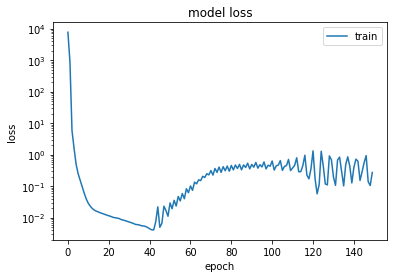

In [ ]:
plt.semilogy(fitres['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()